In [115]:
# Secret key: 1ivd0fqtp4xbx0pqhsv0183ibshswr50pypynvsow5sk2h6yaw
# API key: 353e1ik63ytdkgwm4bfni5vtd
# App token: UMXzWyQUIWIjSyhP5AKzUew4x

from sodapy import Socrata
import pandas as pd
import requests
import json
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
app_token = 'UMXzWyQUIWIjSyhP5AKzUew4x'

client = Socrata("data.cityofnewyork.us", app_token)

In [118]:
# Retrieve the latest PLUTO data 

query = """
Select 
    borough, 
    landuse, 
    BldgClass,
    latitude, 
    longitude,
    zipcode,
    version
where landuse IS NOT NULL and version = '22v1'
limit 1000000
"""

results = client.get("64uk-42ks", query=query)


In [138]:
results_df = pd.DataFrame.from_records(results)
results_gdf = gpd.GeoDataFrame(results_df,
                               geometry=gpd.points_from_xy(results_df.longitude, results_df.latitude))


In [150]:
results_gdf['BldgClass'] = results_gdf['BldgClass'].apply(lambda x: x[0])

In [151]:
results_gdf['BldgClass'].unique()

array(['A', 'B', 'V', 'C', 'K', 'G', 'S', 'M', 'D', 'E', 'R', 'Q', 'I',
       'W', 'O', 'P', 'F', 'Z', 'H', 'N', 'U', 'Y', 'T', 'J'],
      dtype=object)

In [17]:
landuse_dict = {1: 'residential_building',
                2: 'residential_building',
                3: 'residential_building',
                4: 'residential_building',
                5: 'commercial_and_office_building',
                6: 'industrial_and_manufacturing',
                7: 'transport_and_utility',
                8: 'public_facilities_and_institutions',
                9: 'open_space_outdoor_recreation',
                10: 'parking_facilities',
                11: 'vacant_land'}

In [10]:
sf = gpd.read_file("/Users/oliver/Downloads/taxi_zones/taxi_zones.shp")
zones = pd.read_csv("/Users/oliver/Downloads/taxi_zones/taxi+_zone_lookup.csv")


In [11]:
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
sf.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


In [12]:
gdf = gpd.GeoDataFrame(
    pd.merge(zones, sf, on='LocationID', how='inner')
)

gdf.head()

,LocationID,Borough,Zone,service_zone,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry
0,1,EWR,Newark Airport,EWR,1,0.116357,0.000782,Newark Airport,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,Queens,Jamaica Bay,Boro Zone,2,0.433470,0.004866,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,3,0.084341,0.000314,Allerton/Pelham Gardens,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,4,Manhattan,Alphabet City,Yellow Zone,4,0.043567,0.000112,Alphabet City,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,5,Staten Island,Arden Heights,Boro Zone,5,0.092146,0.000498,Arden Heights,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


In [27]:
list(set(landuse_dict.values()))

['commercial_and_office_building',
 'industrial_and_manufacturing',
 'vacant_land',
 'open_space_outdoor_recreation',
 'transport_and_utility',
 'parking_facilities',
 'residential_building',
 'public_facilities_and_institutions']

In [144]:
sjoined_df = gpd.sjoin(results_gdf, gdf, op='within')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs + ...

  """Entry point for launching an IPython kernel.


In [125]:
sjoined_df.columns

Index(['borough_left', 'landuse', 'BldgClass', 'latitude', 'longitude',
       'zipcode', 'version', 'geometry', 'index_right', 'LocationID',
       'Borough', 'Zone', 'service_zone', 'OBJECTID', 'Shape_Leng',
       'Shape_Area', 'zone', 'borough_right', 'commercial_and_office_building',
       'industrial_and_manufacturing', 'vacant_land',
       'open_space_outdoor_recreation', 'transport_and_utility',
       'parking_facilities', 'residential_building',
       'public_facilities_and_institutions'],
      dtype='object')

In [123]:
def sort_category_based_zone(category):
    count_category = sjoined_df.groupby(['LocationID',category]).agg({'OBJECTID':'count'})
    return count_category

In [145]:
building_class = sort_category_based_zone('BldgClass')
zone_major_bldg_class = building_class.sort_values("OBJECTID").groupby(level=0).tail(1).reset_index()[['LocationID', 'BldgClass']]

In [87]:
count_building_category = sjoined_df.groupby(['LocationID','landuse']).agg({'OBJECTID':'count'})

In [89]:
zone_major_landuse = count_building_category.sort_values("OBJECTID").groupby(level=0).tail(1)

In [ ]:
matches.groupby(["FeatureID", "gene"]).count().sort_values("pos").groupby(level=0).tail(1)

In [100]:
zone_major_landuse = zone_major_landuse.sort_index(level=0).reset_index()[['LocationID', 'landuse']]

In [146]:
zone_major_bldg_class

,LocationID,BldgClass
0,103,P7
1,111,Z8
2,199,Y3
3,43,Q1
4,12,O2
...,...,...
254,5,A5
255,205,A1
256,109,A5
257,216,A1


In [152]:
gdf2 = gdf.merge(zone_major_landuse, on='LocationID', how='inner')

In [147]:
gdf3 = gdf.merge(zone_major_bldg_class, on='LocationID', how='inner')

In [148]:
gdf3

,LocationID,Borough,Zone,service_zone,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry,commercial_and_office_building,industrial_and_manufacturing,vacant_land,open_space_outdoor_recreation,transport_and_utility,parking_facilities,residential_building,public_facilities_and_institutions,BldgClass
0,2,Queens,Jamaica Bay,Boro Zone,2,0.433470,0.004866,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q0
1,3,Bronx,Allerton/Pelham Gardens,Boro Zone,3,0.084341,0.000314,Allerton/Pelham Gardens,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B1
2,4,Manhattan,Alphabet City,Yellow Zone,4,0.043567,0.000112,Alphabet City,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C4
3,5,Staten Island,Arden Heights,Boro Zone,5,0.092146,0.000498,Arden Heights,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5
4,6,Staten Island,Arrochar/Fort Wadsworth,Boro Zone,6,0.150491,0.000606,Arrochar/Fort Wadsworth,Staten Island,"POLYGON ((-74.06367 40.60220, -74.06351 40.602...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,259,Bronx,Woodlawn/Wakefield,Boro Zone,259,0.126750,0.000395,Woodlawn/Wakefield,Bronx,"POLYGON ((-73.85107 40.91037, -73.85207 40.909...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B1
258,260,Queens,Woodside,Boro Zone,260,0.133514,0.000422,Woodside,Queens,"POLYGON ((-73.90175 40.76078, -73.90147 40.759...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C0
259,261,Manhattan,World Trade Center,Yellow Zone,261,0.027120,0.000034,World Trade Center,Manhattan,"POLYGON ((-74.01333 40.70503, -74.01327 40.704...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O4
260,262,Manhattan,Yorkville East,Yellow Zone,262,0.049064,0.000122,Yorkville East,Manhattan,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C1


Text(0.5, 1.0, 'Land Usage in Rhodesia')

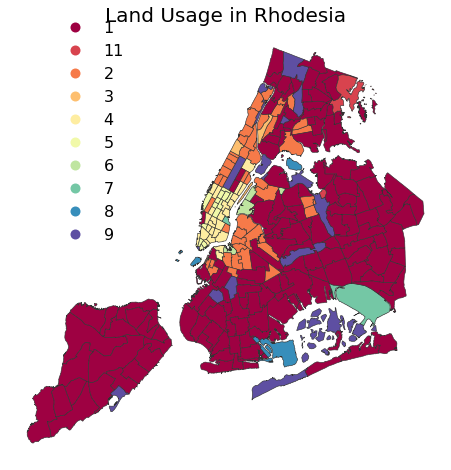

In [155]:
fig, ax = plt.subplots(1, figsize=(14,8))
gdf2.plot(column='landuse', categorical=True, cmap='Spectral', linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(.3, 1.05),'fontsize':16,'frameon':False}, ax=ax)
ax.axis('off')
ax.set_title('Land Usage in Rhodesia',fontsize=20)
